In [1]:
# Load necessary libraries.
library(dplyr)
library(tidyr)
library(readxl)
library(clusterProfiler)
library(org.Mm.eg.db)
library(GO.db)
library(ggplot2)
library(pathview)
library(enrichplot)
library(forcats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




clusterProfiler v4.16.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

G Yu. Thirteen years of clusterProfiler. The Innovation. 2024,
5(6):100722


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following object is masked from ‘package:dplyr’:

    explain


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:dplyr’:

    combine


Th

# Data Preprocessing and Cleaning

The following R code performs essential pre-processing and cleaning steps on the raw dataset. The primary goal is to prepare the data for analysis by:

1. **Loading the Data:** Reading the dataset from an Excel file(`dataset.xlsx`, specifically `Sheet1`).
2. **Splitting by Time Period:** Dividing the columns of the main dataset into three distinct dataframes. Each dataframe corresponds to a specific time interval:
   * **2-Month Data:** Columns A-H
   * **4-Month Data:** Columns J-Q
   * **6-Month Data:** Columns S-Z
3. **Basic Cleaning:** Removing any rows from these newly created dataframes that are entirely blank or contain only `NA` values.

This process transforms the wide-format source data into three separate, cleaner datasets, each representing a specific temporal snapshot (2, 4, and 6 months), ready for further analysis.

In [2]:
parse_data <- function() {
  dataset_file_path <- "./data/dataset.xlsx"
  dataset_sheet <- "Sheet1"

  full_data <- NULL
  df_2month_final <- data.frame()
  df_4month_final <- data.frame()
  df_6month_final <- data.frame()

  # Read in Excel file dataset.
  tryCatch({
    # --- Step 1: Load in all the data from the Excel file ---
    cat("Attempting to read Excel file:", dataset_file_path, ", 
      Sheet:", dataset_sheet, "\n")

    if (!file.exists(dataset_file_path)) {
      stop(paste("File not found at the specified path:", dataset_file_path, 
                 "Current R working directory is:", getwd()))
    }

    full_data <- read_excel(dataset_file_path, sheet = dataset_sheet,
                            col_types = "text", .name_repair = "minimal")
    cat("Excel file read successfully (all columns initially as text).\n")
    cat("Number of columns in full_data after reading:", ncol(full_data), "\n")

    # --- Step 2: Split the data immediately into three dataframes ---
    cat("--- Splitting data into 2-month, 4-month, and 6-month raw dataframes ---\n") #nolint
    cols_2month_indices <- 1:8      # A-H
    cols_4month_indices <- 10:17    # J-Q
    cols_6month_indices <- 19:26    # S-Z

    # Helper function to safely select columns.
    safe_select_cols <- function(df, col_indices, df_name_desc) {
      max_col_needed <- suppressWarnings(max(col_indices, na.rm = TRUE))
      actual_cols_in_df <- ncol(df)

      cat("For", df_name_desc, ": Attempting to select columns",
          min(col_indices), "to", max(col_indices),
          "\n\tMax needed:", max_col_needed, "\n\tActual cols in df:",
          actual_cols_in_df, "\n")

      if (actual_cols_in_df >= max_col_needed && length(col_indices) > 0
          && all(col_indices > 0)) {
        valid_indices <- col_indices[col_indices <= actual_cols_in_df]
        if (length(valid_indices) == length(col_indices)) {
          selected_df <- df %>% dplyr::select(all_of(valid_indices))
          cat(df_name_desc, "created with columns:", 
              paste(names(selected_df), collapse = ", "), "\n")
          return(as.data.frame(selected_df))
        } else {
          cat("Warning: Not all specified column indices for",
              df_name_desc, "are valid.\n\tMax index: ", max_col_needed,
              ", available cols: ", actual_cols_in_df, ".\n")
          return(data.frame())
        }
      } else {
        cat("Warning: Cannot create", df_name_desc,
            "- insufficient columns or invalid indices.\n\tNeeds up to",
            max_col_needed, "columns, available:", actual_cols_in_df, ".\n")
        return(data.frame())
      }
    }

    df_2month <- safe_select_cols(full_data, cols_2month_indices,
                                  "Raw 2-Month Dataframe")
    df_4month <- safe_select_cols(full_data, cols_4month_indices,
                                  "Raw 4-Month Dataframe")
    df_6month <- safe_select_cols(full_data, cols_6month_indices,
                                  "Raw 6-Month Dataframe")

    # --- Step 3: Filter out rows with entries "" or NA for each dataframe ---
    cat("--- Filtering completely blank rows from each dataframe ---\n")

    is_row_entirely_blank <- function(row_vector) {
      all(is.na(row_vector) | trimws(as.character(row_vector)) == "")
    }

    filter_blank_rows <- function(df, df_name) {
      if (nrow(df) > 0 && ncol(df) > 0) {
        rows_to_keep <- !apply(df, 1, is_row_entirely_blank)
        cat("Filtering blank rows for:", df_name,"\n\tOriginal rows:",
            nrow(df), "\n\tRows after filtering:", sum(rows_to_keep), "\n")
        return(df[rows_to_keep, , drop = FALSE])
      } else {
        cat("Skipping blank row filtering for:", df_name,
            "(0 rows or 0 columns).\n")
        return(df)
      }
    }

    df_2month_final <- filter_blank_rows(df_2month, "2-Month Data")
    df_4month_final <- filter_blank_rows(df_4month, "4-Month Data")
    df_6month_final <- filter_blank_rows(df_6month, "6-Month Data (post-shift)")

    # --- Step 4: Print out final dimensions ---
    cat("--- Final Data Dimensions (after all cleaning and filtering) ---\n")
    cat("   2-Month Data (df_2month_final): ",
        paste(dim(df_2month_final), collapse = " x "), "\n")
    cat("   4-Month Data (df_4month_final): ",
        paste(dim(df_4month_final), collapse = " x "), "\n")
    cat("   6-Month Data (df_6month_final): ",
        paste(dim(df_6month_final), collapse = " x "), "\n")

    cat("--- Data parsing and cleaning complete. Returning dataframes as a list. ---\n") #nolint
    return(list(
      df_2month = df_2month_final,
      df_4month = df_4month_final,
      df_6month = df_6month_final
    ))
  }, error = function(e) {
    cat("An error occurred within the parse_data function.\n")
    cat("Specific error message from R (conditionMessage(e)):\n",
        conditionMessage(e), "\n")
    cat("Full error object (e):\n")
    print(e)
    stop(
         paste("Stopping due to error in parse_data function. 
               Original error was:", conditionMessage(e)))
  })
}

In [3]:
processed_data <- parse_data()
if (!is.null(processed_data)) {
  data_2_month <- processed_data$df_2month
  data_4_month <- processed_data$df_4month
  data_6_month <- processed_data$df_6month

  cat("\n--- Head of Unpacked 2-Month Data ---\n")
  print(head(data_2_month))

  cat("\n--- Head of Unpacked 4-Month Data ---\n")
  print(head(data_4_month))

  cat("\n--- Head of Unpacked 6-Month Data ---\n")
  print(head(data_6_month))
} else {
  cat("parse_data() did not return any parsed data, 
      check for errors above.\n")
}

Attempting to read Excel file: ./data/dataset.xlsx , 
      Sheet: Sheet1 
Excel file read successfully (all columns initially as text).
Number of columns in full_data after reading: 27 
--- Splitting data into 2-month, 4-month, and 6-month raw dataframes ---
For Raw 2-Month Dataframe : Attempting to select columns 1 to 8 
	Max needed: 8 
	Actual cols in df: 27 
Raw 2-Month Dataframe created with columns: baseMean, log2FoldChange, FC, lfcSE, pvalue, padj, Gene, threshold 
For Raw 4-Month Dataframe : Attempting to select columns 10 to 17 
	Max needed: 17 
	Actual cols in df: 27 
Raw 4-Month Dataframe created with columns: baseMean, log2FoldChange, FC, lfcSE, pvalue, padj, Gene, threshold 
For Raw 6-Month Dataframe : Attempting to select columns 19 to 26 
	Max needed: 26 
	Actual cols in df: 27 
Raw 6-Month Dataframe created with columns: baseMean, log2FoldChange, FC, lfcSE, pvalue, padj, Gene, threshold 
--- Filtering completely blank rows from each dataframe ---
Filtering blank rows fo

# Gene Ontology Analysis: Cellular Component Mapping

This section delves into the first level of biological analysis, focusing on understanding the **Cellular Components (CC)** associated with the identified gene markers at each time point (2, 4, and 6 months). Gene Ontology (GO) provides a standardized way to describe the functions of genes and proteins across different organisms. Here, the 'Cellular Component' aspect is specifically queried for *Mus musculus* to determine __where__ in a cell the gene markers expressed in the time intervals after stroke onset are typically located or active.

The process involves these key steps for *each* of the three time-point datasets:

1. **Gene Mapping:**
   * The gene symbols extracted from each time-point dataframe are first mapped to their corresponding Entrez Gene IDs using the `org.Mm.eg.db` (Mouse Genome) anntotation database.
   * These Entrez IDs are then mapped to Gene Ontology (GO) terms.
   * The results are filtered to retain only those GO terms that belong to the 'Cellular Component' (CC) ontology.
   * Finally, the GO IDs are translated into human-readable GO term names (e.g. 'nucleus', 'ribosome', 'cytoplasm').
   * This produces a mapping table linking each gene marker to its associated cellular component(s).

2. **Component Counting:**
   * Using the mapping table generated above, the code counts how many distinct gene markers are associated with each unique cellular component.
   * This provides an overview of which cellular locations are most represented by the gene markers at that specific time point.

3. **Identifying Top Components:**
   * The cellular components are ranked based on the number of gene markers.
   * The code then displays the **Top 10** most populared cellular components/locations for each of the 2-month, 4-month, and 6-month intervals.

This analysis helps to create understanding on whether there exists shifts of inconsistencies in the primary cellular locations of interest across the different gene markers recorded across the time periods of this study.         

In [4]:
map_genes_to_go_cc <- function(gene_symbols_list, organism_db) {
  cat("--- Mapping gene symbols to Entrez IDs ---\n")
  entrez_ids <- mapIds(
    organism_db, keys = gene_symbols_list, column = "ENTREZID",
    keytype = "SYMBOL", multiVals = "first"
  )
  gene_map <- data.frame(
    GeneSymbol = names(entrez_ids), ENTREZID = entrez_ids,
    stringsAsFactors = FALSE
  )
  gene_map <- gene_map %>% dplyr::filter(!is.na(ENTREZID))

  if (nrow(gene_map) == 0) {
    cat("\tNo Entrez IDs found for the provided symbols. Returning empty map.\n") #nolint
    return(
      data.frame(GeneSymbol = character(), ENTREZID = character(),
      GO_Term = character()) # nolint
    )
  }
  cat(paste0("\tFound Entrez IDs for ", nrow(gene_map), " symbols.\n"))

  cat("--- Mapping Entrez IDs to GO IDs (Cellular Components only) ---\n")
  go_data <- AnnotationDbi::select(
    organism_db, keys = gene_map$ENTREZID,
    keytype = "ENTREZID", columns = c("GO", "ONTOLOGY")
  )
  go_cc_data <- go_data %>% 
    dplyr::filter(
      ONTOLOGY == "CC" & !is.na(GO)
    ) %>% 
    dplyr::select(ENTREZID, GO_ID = GO)
  go_ids <- unique(go_cc_data$GO_ID)

  if (length(go_ids) > 0) {
    cat("--- Mapping GO IDs to GO Term Names ---\n")
    go_terms_map <- AnnotationDbi::select(
      GO.db, keys = go_ids, keytype = "GOID", columns = "TERM"
    )
    go_terms_map <- go_terms_map %>% dplyr::rename(GO_ID = GOID, GO_Term = TERM)
    go_cc_data <- dplyr::left_join(go_cc_data, go_terms_map, by = "GO_ID")

    cat("--- Creating final Gene-to-Cellular Component map ---\n")
    final_map <- dplyr::left_join(gene_map, go_cc_data, by = "ENTREZID")
    final_map <- final_map %>%
      dplyr::filter(
        !is.na(GO_ID) & !is.na(GO_Term)
      ) %>%
      dplyr::select(
        GeneSymbol, ENTREZID, GO_Term
      ) %>%
      dplyr::distinct()

    cat("--- Mapping Complete ---\n")
    return(final_map) # nolint
  } else {
    cat("--- No GO Cellular Component terms found. Returning empty map. ---\n")
    return(data.frame(GeneSymbol = character(), ENTREZID = character(), GO_Term = character())) # nolint
  }
}

In [5]:
get_go_term_counts <- function(mapping_df) {
  cat("--- Counting gene markers per cellular component ---\n")

  if (exists("mapping_df") && nrow(mapping_df) > 0) {
    go_term_counts <- mapping_df %>% 
      group_by(GO_Term) %>% 
      summarise(
        GeneCount = n_distinct(GeneSymbol),
        .groups = "drop"
      ) %>% 
      arrange(desc(GeneCount))

    cat("--- Gene counts dataframe created ---\n")
    return(go_term_counts) # nolint
  } else {
    cat("--- Cannot create counts: Input dataframe is empty or does not exist. ---\n") # nolint
    return(data.frame(GO_Term = character(), GeneCount = integer())) # nolint
  }
}

In [6]:
cat("--- Extracting gene symbols from 2, 4, and 6 months dataframes ---\n")
genes_2_month <- data_2_month$Gene
genes_4_month <- data_4_month$Gene
genes_6_month <- data_6_month$Gene

cat("\n--- Processing 2-Month Gene Data ---\n")
final_2_month_map <- map_genes_to_go_cc(genes_2_month, org.Mm.eg.db)
go_term_counts_2m <- get_go_term_counts(final_2_month_map)
cat("--- Top 10 most populated cellular components (2-Month data) ---\n")
print(head(go_term_counts_2m, 10))

cat("\n\n--- Processing 4-Month Gene Data ---\n")
final_4_month_map <- map_genes_to_go_cc(genes_4_month, org.Mm.eg.db)
go_term_counts_4m <- get_go_term_counts(final_4_month_map)
cat("--- Top 10 most populated cellular components (4-Month data) ---\n")
print(head(go_term_counts_4m, 10))

cat("\n\n--- Processing 6-Month Gene Data ---\n")
final_6_month_map <- map_genes_to_go_cc(genes_6_month, org.Mm.eg.db)
go_term_counts_6m <- get_go_term_counts(final_6_month_map)
cat("--- Top 10 most populated cellular components (6-Month data) ---\n")
print(head(go_term_counts_6m, 10))

--- Extracting gene symbols from 2, 4, and 6 months dataframes ---

--- Processing 2-Month Gene Data ---


--- Mapping gene symbols to Entrez IDs ---


'select()' returned 1:1 mapping between keys and columns



	Found Entrez IDs for 11750 symbols.
--- Mapping Entrez IDs to GO IDs (Cellular Components only) ---


'select()' returned 1:many mapping between keys and columns



--- Mapping GO IDs to GO Term Names ---


'select()' returned 1:1 mapping between keys and columns



--- Creating final Gene-to-Cellular Component map ---
--- Mapping Complete ---
--- Counting gene markers per cellular component ---
--- Gene counts dataframe created ---
--- Top 10 most populated cellular components (2-Month data) ---
# A tibble: 10 × 2
   GO_Term               GeneCount
   <chr>                     <int>
 1 cytoplasm                  3954
 2 nucleus                    3761
 3 cytosol                    2959
 4 plasma membrane            2561
 5 nucleoplasm                2504
 6 membrane                   1464
 7 mitochondrion              1340
 8 cellular_component          961
 9 endoplasmic reticulum       831
10 Golgi apparatus             801


--- Processing 4-Month Gene Data ---
--- Mapping gene symbols to Entrez IDs ---


'select()' returned 1:1 mapping between keys and columns



	Found Entrez IDs for 13895 symbols.
--- Mapping Entrez IDs to GO IDs (Cellular Components only) ---


'select()' returned 1:many mapping between keys and columns



--- Mapping GO IDs to GO Term Names ---


'select()' returned 1:1 mapping between keys and columns



--- Creating final Gene-to-Cellular Component map ---
--- Mapping Complete ---
--- Counting gene markers per cellular component ---
--- Gene counts dataframe created ---
--- Top 10 most populated cellular components (4-Month data) ---
# A tibble: 10 × 2
   GO_Term               GeneCount
   <chr>                     <int>
 1 cytoplasm                  4446
 2 nucleus                    4196
 3 cytosol                    3263
 4 plasma membrane            2998
 5 nucleoplasm                2763
 6 membrane                   1670
 7 mitochondrion              1454
 8 cellular_component         1424
 9 endoplasmic reticulum       913
10 Golgi apparatus             888


--- Processing 6-Month Gene Data ---
--- Mapping gene symbols to Entrez IDs ---


'select()' returned 1:1 mapping between keys and columns



	Found Entrez IDs for 11143 symbols.
--- Mapping Entrez IDs to GO IDs (Cellular Components only) ---


'select()' returned 1:many mapping between keys and columns



--- Mapping GO IDs to GO Term Names ---


'select()' returned 1:1 mapping between keys and columns



--- Creating final Gene-to-Cellular Component map ---
--- Mapping Complete ---
--- Counting gene markers per cellular component ---
--- Gene counts dataframe created ---
--- Top 10 most populated cellular components (6-Month data) ---
# A tibble: 10 × 2
   GO_Term               GeneCount
   <chr>                     <int>
 1 cytoplasm                  3798
 2 nucleus                    3617
 3 cytosol                    2858
 4 nucleoplasm                2436
 5 plasma membrane            2423
 6 membrane                   1399
 7 mitochondrion              1298
 8 cellular_component          838
 9 endoplasmic reticulum       804
10 Golgi apparatus             781


# Identifying and Analyzing Differentially Expressed Genes

While the previous analysis looked at all gene markers present at each time point, this section focuses on identifying genes that show **statistically significant** and **biologically meaningful** changes in their expression levels. The Cellular Component (CC) distribution is re-examined for *only* this subset of key genes.

The process is as listed:

1. **Data Type Conversion:** As a preliminary step, columns containing numerical data (like fold change and p-values), which were initially read as text, are converted back to their proper numeric types. This allows for numerical filtering and sorting to be done on the data.

2. **Statistical Significance Filtering:**
   * For each time point (2, 4, and 6 months), the data is filtered to retain only those genes with an **adjusted p-value (padj) less than 0.05**.
   * The `padj` value indicates the probability of observing the expression change (or a more extreme one) by chance, adjusted for multiple comparisons. A `padj < 0.05` threshold is the common standard for identification of statsitical significances.
   * The code then displays the top 10 most statistically significant genes (lowest `padj`) for each time interval.

3. **Differential Expression Filtering:**
   * The statistically significant genes identified in the previous step are filtered based on the magnitude of their expression change, using the **log2 Fold Change (log2FC)**.
   * Genes where the **absolute value of `log2FoldChange` is greater than or equal to 1** are selected, as they denote genes with expression levels that have at least doubled (log2FC >= 1) or halved (log2FC <= -1) compared to the control or baseline condition.
   * These genes are considered *differentially expressed* - showing both statistical and biological significance.
   * The code displays the top 10 differentially expressed genes (highest absolute fold change) for each time point.

4. **Cellular Component Analysis of Differentially Expressed Genes:**
   * The list of the *differentially expressed* genes are extracted for each time point.
   * The `map_genes_to_go_cc` and `get_go_term_counts` functions (used in the previous part of the analysis) are called again, but this time applied *only* to the filtered gene lists identified.
   * This identifies the cellular components most populated by genes exhibiting significant expression changes.
   * The top 10 most populated cellular components for these key genes are displayed for each time interval.

The targeted analysis conducted in this part helps pinpoint the specific cellular locations where the most significant biological activity and changes are likely to occur at 2, 4, and 6 months after stroke onset within mice.       

In [7]:
# --- Step 1: Convert numeric-data columns in dataframes back to numeric ---
cols_to_convert <- c(
  "baseMean", "log2FoldChange", "FC",
  "lfcSE", "pvalue", "padj"
)
data_2_month[cols_to_convert] <- lapply(
  data_2_month[cols_to_convert],
  function(x) as.numeric(as.character(x))
)
data_4_month[cols_to_convert] <- lapply(
  data_4_month[cols_to_convert],
  function(x) as.numeric(as.character(x))
)
data_6_month[cols_to_convert] <- lapply(
  data_6_month[cols_to_convert],
  function(x) as.numeric(as.character(x))
)

# --- Step 2: Filter for genes with statistically significant padj ---
cat("--- Filtering for statistically significant expressed genes ---\n")
stat_sig_2_month <- data_2_month[data_2_month$padj < 0.05, ]
stat_sig_4_month <- data_4_month[data_4_month$padj < 0.05, ]
stat_sig_6_month <- data_6_month[data_6_month$padj < 0.05, ]

cat("--- Sorting statistically significant expressed genes in ascending order ---\n") # nolint
stat_sig_2_month <- stat_sig_2_month[order(stat_sig_2_month$padj), ]
stat_sig_4_month <- stat_sig_4_month[order(stat_sig_4_month$padj), ]
stat_sig_6_month <- stat_sig_6_month[order(stat_sig_6_month$padj), ]

cat("--- Top 10 statistically significant expressed gene markers ---\n")
cat("\tFor 2-Month Data:\n")
head(stat_sig_2_month[, c("Gene", "padj", "log2FoldChange")], 10)
cat("\tFor 4-Month Data:\n")
head(stat_sig_4_month[, c("Gene", "padj", "log2FoldChange")], 10)
cat("\tFor 6-Month Data:\n")
head(stat_sig_6_month[, c("Gene", "padj", "log2FoldChange")], 10)

# --- Step 3: Filter for genes with differentially significant log2FoldChange --- # nolint
cat("\n--- Filtering for differentially significant expressed genes ---\n")
diff_sig_2_month <- stat_sig_2_month[
  abs(stat_sig_2_month$log2FoldChange) >= 1,
]
diff_sig_4_month <- stat_sig_4_month[
  abs(stat_sig_4_month$log2FoldChange) >= 1,
]
diff_sig_6_month <- stat_sig_6_month[
  abs(stat_sig_6_month$log2FoldChange) >= 1,
]

cat("--- Sorting differentially significant expressed genes in ascending order ---\n") # nolint
diff_sig_2_month <- diff_sig_2_month[order(-diff_sig_2_month$log2FoldChange), ]
diff_sig_4_month <- diff_sig_4_month[order(-diff_sig_4_month$log2FoldChange), ]
diff_sig_6_month <- diff_sig_6_month[order(-diff_sig_6_month$log2FoldChange), ]

cat("--- Top 10 differentially significant expressed gene markers ---\n")
cat("\tFor 2-Month Data:\n")
head(diff_sig_2_month[, c("Gene", "log2FoldChange", "padj")], 10)
cat("\tFor 4-Month Data:\n")
head(diff_sig_4_month[, c("Gene", "log2FoldChange", "padj")], 10)
cat("\tFor 6-Month Data:\n")
head(diff_sig_6_month[, c("Gene", "log2FoldChange", "padj")], 10)


--- Filtering for statistically significant expressed genes ---
--- Sorting statistically significant expressed genes in ascending order ---
--- Top 10 statistically significant expressed gene markers ---
	For 2-Month Data:


,Gene,padj,log2FoldChange
,<chr>,<dbl>,<dbl>
8,Sgtb,6.45e-14,1.6027191
12233,Psap,6.45e-14,-1.1430573
20,B230209E15Rik,8.31e-13,1.4163571
143,Cacna2d1,1.42e-11,1.0037239
22,Pdia3,2.24e-11,1.4102514
12235,Fn3krp,1.07e-10,-1.2418911
12223,Bod1,1.35e-10,-0.9435003
68,Scn1a,3.47e-10,1.1569485
219,Zfr,4.05e-10,0.8983948


	For 4-Month Data:


,Gene,padj,log2FoldChange
,<chr>,<dbl>,<dbl>
6,Cyb5r1,1.06e-27,2.406415
8,Chac1,1.02e-24,2.309262
7,Ddit3,1.54e-23,2.326177
17,Slc7a3,1.04e-14,1.765309
18,Shmt2,1.01e-12,1.703655
12,Eif4ebp1,1.25e-11,2.113998
32,Asns,1.37e-11,1.155140
34,Eif3c,2.74e-11,1.084101
23,Sars,4.44e-11,1.344610


	For 6-Month Data:


,Gene,padj,log2FoldChange
,<chr>,<dbl>,<dbl>
10,Gfap,3.34e-36,2.0113187
13,Ddit3,4.36e-34,1.9053700
18,2410006H16Rik,5.32e-26,1.6580943
11574,Tubb4b,9.48e-20,-1.2705916
88,Nars,5.20e-17,0.8555082
7,Slc7a3,3.88e-15,2.2395602
9,Cyb5r1,3.15e-14,2.0672091
19,Shmt2,2.24e-13,1.6550448
16,Chac1,1.70e-12,1.7744999



--- Filtering for differentially significant expressed genes ---
--- Sorting differentially significant expressed genes in ascending order ---
--- Top 10 differentially significant expressed gene markers ---
	For 2-Month Data:


,Gene,log2FoldChange,padj
,<chr>,<dbl>,<dbl>
1,Mterf3,2.084262,1.86000e-05
2,mt-Rnr2,1.858896,4.22000e-05
3,mt-Tq,1.855876,1.88000e-05
4,Rab5a,1.764239,4.62000e-05
5,Nrn1,1.683602,2.80000e-08
6,mt-Ta,1.679650,1.82000e-06
7,mt-Rnr1,1.629980,3.97000e-05
8,Sgtb,1.602719,6.45000e-14
9,mt-Tl1,1.592974,1.22659e-04


	For 4-Month Data:


,Gene,log2FoldChange,padj
,<chr>,<dbl>,<dbl>
1,Car6,5.274366,1.365119e-02
2,Trib3,3.395685,3.790000e-08
3,Cyb5r2,3.110813,4.020000e-05
5,Sesn2,2.603943,2.279330e-04
6,Cyb5r1,2.406415,1.060000e-27
7,Ddit3,2.326177,1.540000e-23
8,Chac1,2.309262,1.020000e-24
11,Stc2,2.187558,4.830909e-03
12,Eif4ebp1,2.113998,1.250000e-11


	For 6-Month Data:


,Gene,log2FoldChange,padj
,<chr>,<dbl>,<dbl>
1,Cst7,4.060601,9.18000e-05
2,Cyb5r2,2.634252,1.98021e-04
3,Ifit1,2.474842,1.30719e-04
4,Fibin,2.261958,1.98021e-04
5,Oasl2,2.248503,1.34000e-06
6,Ifi44,2.243647,8.85900e-04
7,Slc7a3,2.239560,3.88000e-15
8,Sesn2,2.116798,2.17831e-04
9,Cyb5r1,2.067209,3.15000e-14


In [8]:
# --- Step 1: Determining cellular components of overly expressed genes ---
cat("--- Extracting overly expressed genes from 2, 4, and 6 months data ---\n")
over_exp_genes_2m <- diff_sig_2_month$Gene
over_exp_genes_4m <- diff_sig_4_month$Gene
over_exp_genes_6m <- diff_sig_6_month$Gene


cat("--- Mapping overly expressed genes to cellular components ---\n")
over_exp_2m_go_cc <- map_genes_to_go_cc(over_exp_genes_2m, org.Mm.eg.db)
over_exp_2m_go_cc_counts <- get_go_term_counts(over_exp_2m_go_cc)

over_exp_4m_go_cc <- map_genes_to_go_cc(over_exp_genes_4m, org.Mm.eg.db)
over_exp_4m_go_cc_counts <- get_go_term_counts(over_exp_4m_go_cc)

over_exp_6m_go_cc <- map_genes_to_go_cc(over_exp_genes_6m, org.Mm.eg.db)
over_exp_6m_go_cc_counts <- get_go_term_counts(over_exp_6m_go_cc)

cat("--- Top 10 most populated cellular components among overly expressed genes (2-Month Data) ---\n") # nolint
print(head(over_exp_2m_go_cc_counts, 10))

cat("--- Top 10 most populated cellular components among overly expressed genes (4-Month Data) ---\n") # nolint
print(head(over_exp_4m_go_cc_counts, 10))

cat("--- Top 10 most populated cellular components among overly expressed genes (6-Month Data) ---\n") # nolint
print(head(over_exp_6m_go_cc_counts, 10))

--- Extracting overly expressed genes from 2, 4, and 6 months data ---
--- Mapping overly expressed genes to cellular components ---
--- Mapping gene symbols to Entrez IDs ---


'select()' returned 1:1 mapping between keys and columns



	Found Entrez IDs for 144 symbols.
--- Mapping Entrez IDs to GO IDs (Cellular Components only) ---


'select()' returned 1:many mapping between keys and columns



--- Mapping GO IDs to GO Term Names ---


'select()' returned 1:1 mapping between keys and columns



--- Creating final Gene-to-Cellular Component map ---
--- Mapping Complete ---
--- Counting gene markers per cellular component ---
--- Gene counts dataframe created ---
--- Mapping gene symbols to Entrez IDs ---


'select()' returned 1:1 mapping between keys and columns



	Found Entrez IDs for 32 symbols.
--- Mapping Entrez IDs to GO IDs (Cellular Components only) ---


'select()' returned 1:many mapping between keys and columns



--- Mapping GO IDs to GO Term Names ---


'select()' returned 1:1 mapping between keys and columns



--- Creating final Gene-to-Cellular Component map ---
--- Mapping Complete ---
--- Counting gene markers per cellular component ---
--- Gene counts dataframe created ---
--- Mapping gene symbols to Entrez IDs ---


'select()' returned 1:1 mapping between keys and columns



	Found Entrez IDs for 81 symbols.
--- Mapping Entrez IDs to GO IDs (Cellular Components only) ---


'select()' returned 1:many mapping between keys and columns



--- Mapping GO IDs to GO Term Names ---


'select()' returned 1:1 mapping between keys and columns



--- Creating final Gene-to-Cellular Component map ---
--- Mapping Complete ---
--- Counting gene markers per cellular component ---
--- Gene counts dataframe created ---
--- Top 10 most populated cellular components among overly expressed genes (2-Month Data) ---
# A tibble: 10 × 2
   GO_Term                    GeneCount
   <chr>                          <int>
 1 nucleus                           55
 2 cytoplasm                         44
 3 nucleoplasm                       40
 4 cytosol                           34
 5 plasma membrane                   26
 6 mitochondrion                     16
 7 membrane                          14
 8 centrosome                        12
 9 cellular_component                11
10 protein-containing complex        11
--- Top 10 most populated cellular components among overly expressed genes (4-Month Data) ---
# A tibble: 10 × 2
   GO_Term              GeneCount
   <chr>                    <int>
 1 nucleus                     11
 2 cytoplasm          

# Over-Representation Analysis (ORA) for Time-Course Data

The next part of the analysis aims at identifying enriched Gene Ontology (GO) terms among differentially expressed (DEGs) across three time points of 2 months, 4 months, and 6 months after stroke onset in mice.

## Data Preparation
1. **Combine Data Across Time Points:** Gene expression data from 2m, 4m, and 6m were combined into a single `all_data` dataframe with a `Timepoint` columns.

2. **Define Gene Universe:**
   * Extract all genes with non-NA adjusted p-values into `all_measured_gene_symbols`.
   * Map gene symbols to Entrez IDs using `org.Mm.eg.db`, removing unmapped entries to define `global_universe_entrez`.

## DEG Identification
   * Two functions identify significantly upregulated and downregualted genes:
     - Criteria: `padj < 0.05` and `|log2FoldChange| >= 1`
     - Results are mapped to Entrez IDs, generating six DEG sets:
       - `degs_2m_up`, `degs_2m_down`
       - `degs_4m_up`, `degs_4m_down`
       - `degs_6m_up`, `degs_6m_down`

## GO Enrichment Analysis
* **Function:** `run_ora_set` wraps `enrichGO()` from the `clusterProfiler` package.
* **Parameters:**
  - `gene`: DEG list (Entrez IDs)
  - `universe`: `global_universe_entrez`
  - `OrgDb`: `Org.Mm.eg.db`
  - `ont`: `"BP"`, `"MF"`, or `"CC"`
  - `pAdjustMethod`: `"BH"`
  - `pvalueCutoff`, `qvalueCutoff`: significance thresholds
  - `readable = TRUE`: maps results back to gene symbols
* **Total Calls:** 18 (6 DEG sets x 3 ontologies)  

## Visualization
1. **Combine Ontology Results:**
   * `combine_ora_results()` merges BP, MF, and CC results for each DEG set
   * Adds an `ONTOLOGY` column
2. **Format Data for Plotting:**
   * `select_and_order_data_all()` sorts terms by gene count and standardizes color coding
3. **Generate Bar Plots:**
   * `create_go_barplot()` produces GO term barplots with:
     - x-axis: GO term (Description)
     - y-axis: Gene Count
     - Color: Ontology (BP, MF, CC)
     - Enhanced readability with rotated labels
4. **Final Output**:
   * One plot per DEG set: 2m-up, 2m-down, 4m-up, 4m-down, 6m-up, 6m-down        

In [ ]:
all_data <- bind_rows(
  data_2_month %>% mutate(Timepoint = "2m"),
  data_4_month %>% mutate(Timepoint = "4m"),
  data_6_month %>% mutate(Timepoint = "6m")
)

all_measured_gene_symbols <- all_data %>%
  dplyr::filter(!is.na(padj)) %>%
  pull(Gene) %>%
  unique()

cat(paste(
  "Total unique measured gene symbols across all timepoints:",
  length(all_measured_gene_symbols), "\n"
))

global_universe_entrez <- mapIds(
  org.Mm.eg.db, keys = all_measured_gene_symbols, column = "ENTREZID",
  keytype = "SYMBOL", multiVals = "first"
)

global_universe_entrez <- na.omit(unique(global_universe_entrez))
cat(paste(
  "Total unique Entrez IDs for global universe:", 
  length(global_universe_entrez), "\n"
))

Total unique measured gene symbols across all timepoints: 14554 


'select()' returned 1:1 mapping between keys and columns



Total unique Entrez IDs for global universe: 13898 


In [10]:
find_significant_up_entrez <- function(df, p_cutoff = 0.05, fc_cutoff = 1) {
  sig_genes <- df %>% 
  dplyr::filter(
    padj < p_cutoff & log2FoldChange >= fc_cutoff
  ) %>% 
  pull(Gene) %>% unique()
  sig_entrez <- mapIds(
    org.Mm.eg.db, keys = sig_genes, 
    column = "ENTREZID", keytype = "SYMBOL", 
    multiVals = "first"
  )
  sig_entrez <- na.omit(unique(sig_entrez))
  cat(paste(
    "Found ", length(sig_entrez), 
    " significant upregulated Entrez IDs.\n"
  ))
  return(sig_entrez)
}

In [ ]:
find_significant_down_entrez <- function(df, p_cutoff = 0.05, fc_cutoff = -1) {
  sig_genes <- df %>%
    dplyr::filter(padj < p_cutoff & log2FoldChange <= fc_cutoff) %>%
    pull(Gene) %>%
    unique()
  sig_entrez <- mapIds(
    org.Mm.eg.db, keys = sig_genes, 
    column = "ENTREZID", keytype = "SYMBOL", 
    multiVals = "first"
  )
  sig_entrez <- na.omit(unique(sig_entrez))
  cat(paste(
    "Found ", length(sig_entrez), " significant downregulated Entrez IDs.\n"
  ))
  return(sig_entrez)
}

In [12]:
degs_2m_up <- find_significant_up_entrez(data_2_month)
degs_2m_down <- find_significant_down_entrez(data_2_month)

degs_4m_up <- find_significant_up_entrez(data_4_month)
degs_4m_down <- find_significant_down_entrez(data_4_month)

degs_6m_up <- find_significant_up_entrez(data_6_month)
degs_6m_down <- find_significant_down_entrez(data_6_month)

'select()' returned 1:1 mapping between keys and columns



Found  138  significant upregulated Entrez IDs.


'select()' returned 1:1 mapping between keys and columns



Found  6  significant downregulated Entrez IDs.


'select()' returned 1:1 mapping between keys and columns



Found  24  significant upregulated Entrez IDs.


'select()' returned 1:1 mapping between keys and columns



Found  8  significant downregulated Entrez IDs.


'select()' returned 1:1 mapping between keys and columns



Found  58  significant upregulated Entrez IDs.


'select()' returned 1:1 mapping between keys and columns



Found  23  significant downregulated Entrez IDs.


In [13]:
run_ora_set <- function(gene_list, universe, ont_type) {
  enrichGO(
    gene = gene_list,
    universe = universe,
    OrgDb = org.Mm.eg.db,
    keyType = "ENTREZID",
    ont = ont_type,
    pAdjustMethod = "BH",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.2,
    readable = TRUE
  )
}

In [14]:
cat("--- Performing ORA for 2-Month Upregulated Genes ---\n")
ora_2m_up_bp <- run_ora_set(degs_2m_up, global_universe_entrez, "BP")
ora_2m_up_mf <- run_ora_set(degs_2m_up, global_universe_entrez, "MF")
ora_2m_up_cc <- run_ora_set(degs_2m_up, global_universe_entrez, "CC")

cat("--- Performing ORA for 2-Month Downregulated Genes ---\n")
ora_2m_down_bp <- run_ora_set(degs_2m_down, global_universe_entrez, "BP")
ora_2m_down_mf <- run_ora_set(degs_2m_down, global_universe_entrez, "MF")
ora_2m_down_cc <- run_ora_set(degs_2m_down, global_universe_entrez, "CC")

--- Performing ORA for 2-Month Upregulated Genes ---
--- Performing ORA for 2-Month Downregulated Genes ---


In [15]:
cat("--- Performing ORA for 4-Month Upregulated Genes ---\n")
ora_4m_up_bp <- run_ora_set(degs_4m_up, global_universe_entrez, "BP")
ora_4m_up_mf <- run_ora_set(degs_4m_up, global_universe_entrez, "MF")
ora_4m_up_cc <- run_ora_set(degs_4m_up, global_universe_entrez, "CC")

cat("--- Performing ORA for 4-Month Downregulated Genes ---\n")
ora_4m_down_bp <- run_ora_set(degs_4m_down, global_universe_entrez, "BP")
ora_4m_down_mf <- run_ora_set(degs_4m_down, global_universe_entrez, "MF")
ora_4m_down_cc <- run_ora_set(degs_4m_down, global_universe_entrez, "CC")

--- Performing ORA for 4-Month Upregulated Genes ---


--- Performing ORA for 4-Month Downregulated Genes ---


In [16]:
cat("--- Performing ORA for 6-Month Upregulated Genes ---\n")
ora_6m_up_bp <- run_ora_set(degs_6m_up, global_universe_entrez, "BP")
ora_6m_up_mf <- run_ora_set(degs_6m_up, global_universe_entrez, "MF")
ora_6m_up_cc <- run_ora_set(degs_6m_up, global_universe_entrez, "CC")

cat("--- Performing ORA for 6-Month Downregulated Genes ---\n")
ora_6m_down_bp <- run_ora_set(degs_6m_down, global_universe_entrez, "BP")
ora_6m_down_mf <- run_ora_set(degs_6m_down, global_universe_entrez, "MF")
ora_6m_down_cc <- run_ora_set(degs_6m_down, global_universe_entrez, "CC")

--- Performing ORA for 6-Month Upregulated Genes ---


--- Performing ORA for 6-Month Downregulated Genes ---


In [17]:
combine_ora_results <- function(bp_res, mf_res, cc_res) {
  bp_df <- as.data.frame(bp_res) %>% mutate(ONTOLOGY = "BP")
  mf_df <- as.data.frame(mf_res) %>% mutate(ONTOLOGY = "MF")
  cc_df <- as.data.frame(cc_res) %>% mutate(ONTOLOGY = "CC")

  results <- list()
  if (nrow(bp_df) > 0) results$bp <- bp_df
  if (nrow(mf_df) > 0) results$mf <- mf_df
  if (nrow(cc_df) > 0) results$cc <- cc_df

  if (length(results) > 0) {
    return(bind_rows(results))
  } else {
    return(data.frame())
  }
}

In [ ]:
ora_2m_up_combined <- combine_ora_results(
  ora_2m_up_bp, ora_2m_up_mf, ora_2m_up_cc
)
ora_2m_down_combined <- combine_ora_results(
  ora_2m_down_bp, ora_2m_down_mf, ora_2m_down_cc
)

In [20]:
select_and_order_data_all <- function(df) {
  if (nrow(df) == 0) return(df)

  df %>%
    mutate(
      ONTOLOGY = factor(
        ONTOLOGY, levels = c("MF", "CC", "BP")
      )
    ) %>%
    arrange(ONTOLOGY, -Count) %>%
    mutate(Description = fct_inorder(Description))
}

In [21]:
plot_data_2m_up <- select_and_order_data_all(ora_2m_up_combined)
plot_data_2m_down <- select_and_order_data_all(ora_2m_down_combined)

go_colors <- c("MF" = "blue", "CC" = "green", "BP" = "red")

In [29]:
create_go_barplot <- function(plot_df, plot_title, bar_width = 0.7) {
  if (nrow(plot_df) == 0) {
    return(ggplot() + labs(title = paste(plot_title), "(No significant terms)"))
  }

  ggplot(plot_df, aes(x = Description, y = Count, fill = ONTOLOGY)) +
    geom_col(width = bar_width) +
    scale_fill_manual(
      values = go_colors,
      name = "GO Ontology"
    ) +
    labs(
      title = plot_title,
      x = "GO Term",
      y = "Protein Count"
    ) +
    theme_minimal(base_size = 10) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold"),
      axis.text.x = element_text(
        angle = 90,
        hjust = 1,
        vjust = 1,
        size = 5
      ),
      axis.text.y = element_text(size = 8),
      legend.position = "bottom"
    )
}

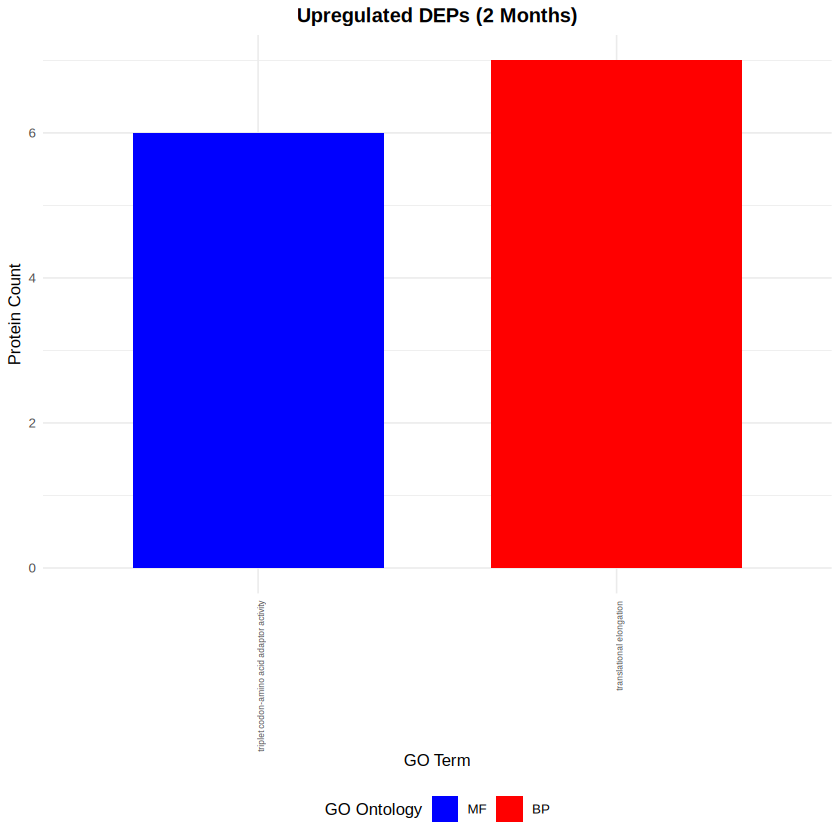

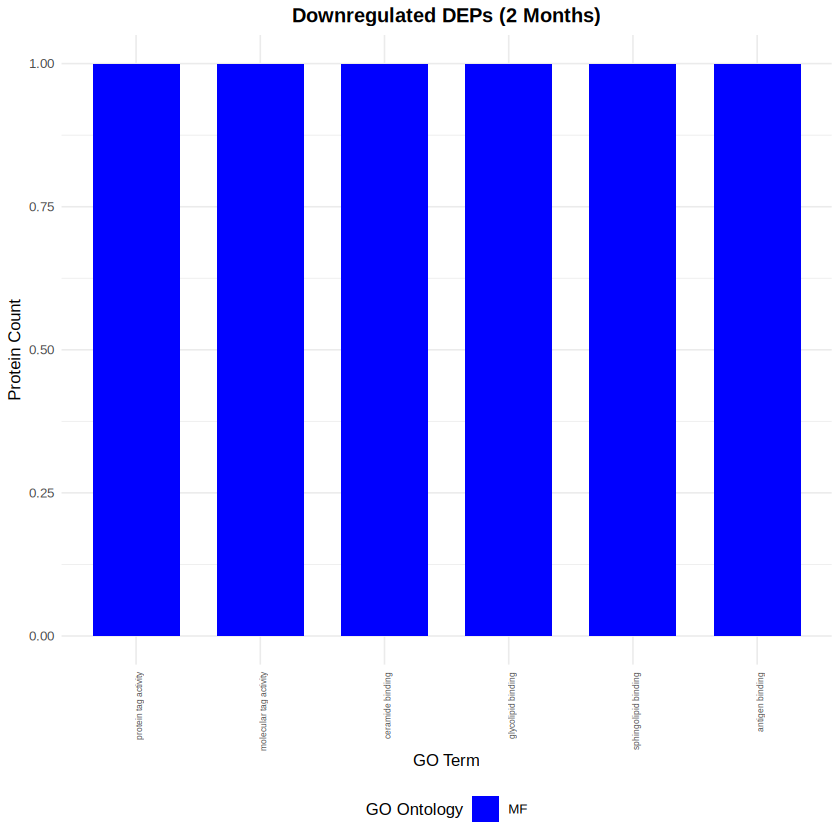

In [30]:
plot_up_2m <- create_go_barplot(
  plot_data_2m_up, "Upregulated DEPs (2 Months)"
)
plot_down_2m <- create_go_barplot(
  plot_data_2m_down, "Downregulated DEPs (2 Months)"
)

print(plot_up_2m)
print(plot_down_2m)

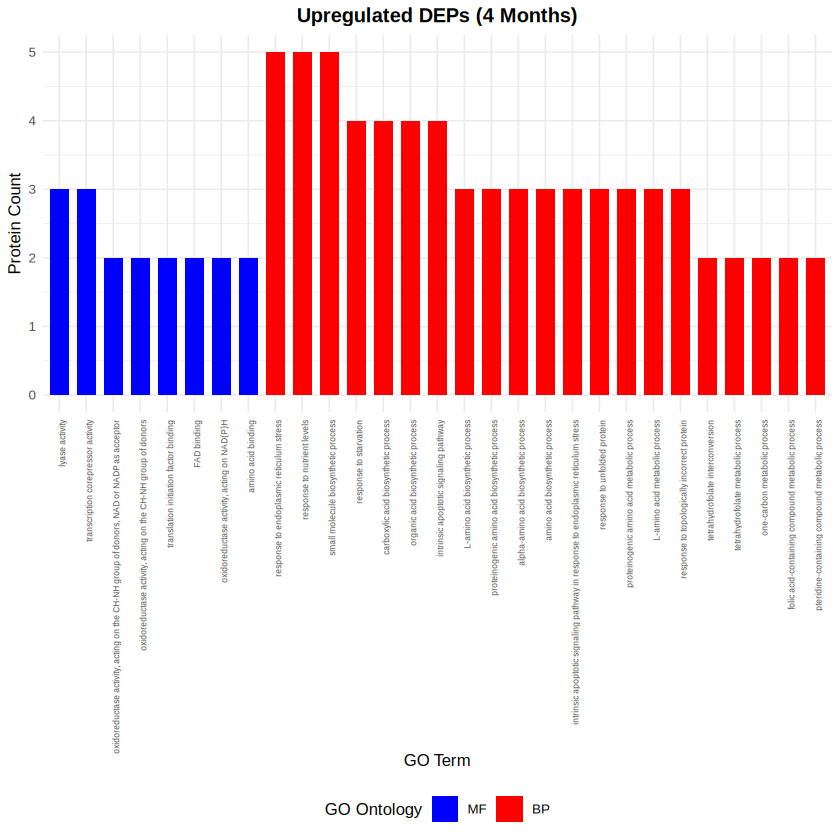

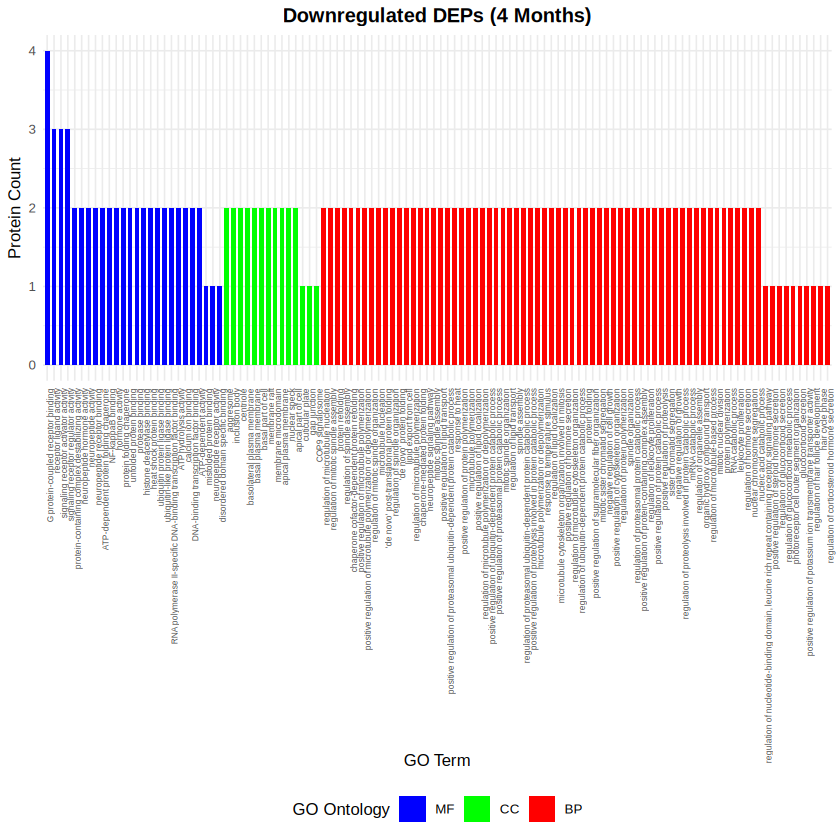

In [31]:
ora_4m_up_combined <- combine_ora_results(
  ora_4m_up_bp, ora_4m_up_mf, ora_4m_up_cc
)
ora_4m_down_combined <- combine_ora_results(
  ora_4m_down_bp, ora_4m_down_mf, ora_4m_down_cc
)

plot_data_4m_up <- select_and_order_data_all(ora_4m_up_combined)
plot_data_4m_down <- select_and_order_data_all(ora_4m_down_combined)

plot_up_4m <- create_go_barplot(
  plot_data_4m_up, "Upregulated DEPs (4 Months)"
)
plot_down_4m <- create_go_barplot(
  plot_data_4m_down, "Downregulated DEPs (4 Months)"
)

print(plot_up_4m)
print(plot_down_4m)


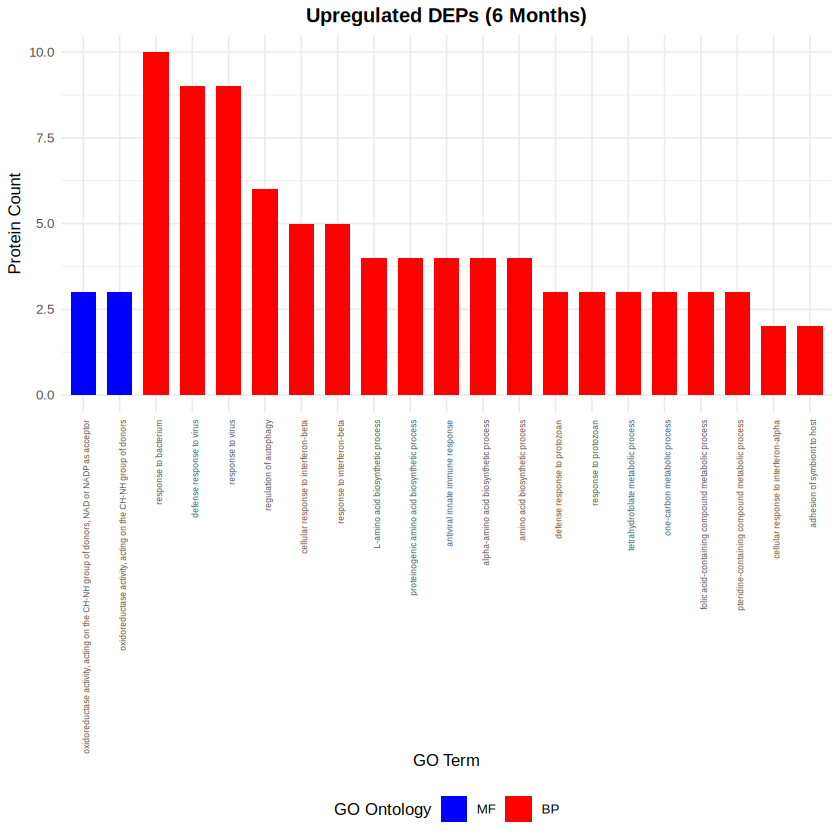

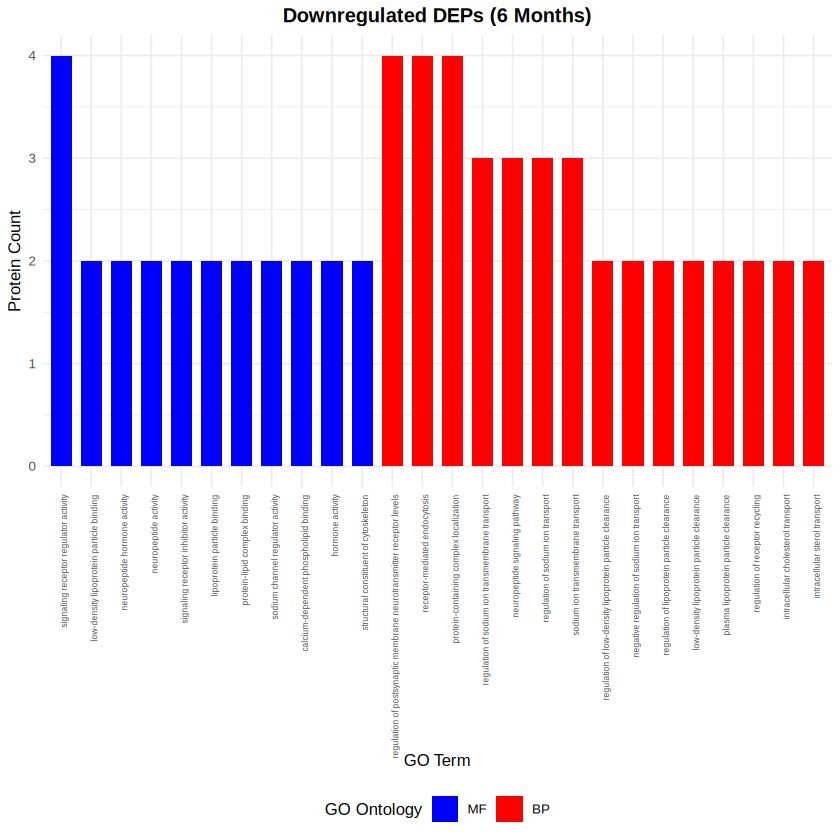

In [32]:
ora_6m_up_combined <- combine_ora_results(
  ora_6m_up_bp, ora_6m_up_mf, ora_6m_up_cc
)
ora_6m_down_combined <- combine_ora_results(
  ora_6m_down_bp, ora_6m_down_mf, ora_6m_down_cc
)

plot_data_6m_up <- select_and_order_data_all(ora_6m_up_combined)
plot_data_6m_down <- select_and_order_data_all(ora_6m_down_combined)

plot_up_6m <- create_go_barplot(
  plot_data_6m_up, "Upregulated DEPs (6 Months)"
)
plot_down_6m <- create_go_barplot(
  plot_data_6m_down, "Downregulated DEPs (6 Months)"
)

print(plot_up_6m)
print(plot_down_6m)
